In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import numpy as np
from sourcesep.models.nmf_variants import set_norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


def gaussfn(x, mu, sig): return 1/(np.sqrt(2*np.pi)*sig) * \
    np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

n_sources = 3
n_wavelengths = 200
n_timepoints = 100
n_channels = 3

# spectra for the sources:
s = {}
s[0] = gaussfn(np.arange(n_wavelengths), mu=20, sig=15)
s[1] = gaussfn(np.arange(n_wavelengths), mu=40, sig=15)
s[2] = gaussfn(np.arange(n_wavelengths), mu=80, sig=15)

for i in range(n_sources):
    s[i] = set_norm(s[i], axis=0, c=np.sqrt(n_wavelengths))[0]

# efficiency of emission per channel
s_ch = {}
s_ch[0] = np.array([1.0, 0.0, 0.0])
s_ch[1] = np.array([0.0, 1.0, 0.0])
s_ch[2] = np.array([0.0, 0.0, 1.0])

a_col = {}
for ch in range(n_channels):
    a_col[ch] = np.concatenate([s_ch[ch][src]*s[src] for src in range(n_sources)])
    a_col[ch] = a_col[ch].reshape(-1,1)

A = np.concatenate([a_col[i] for i in range(n_sources)], axis=1)

# time series
h_init_ab = 0.5 * np.abs(np.random.rand(1, n_timepoints))
h_init_c = 0.5 * np.abs(np.random.rand(1, n_timepoints))
H = np.concatenate([1.0+0.3*h_init_ab,
                    1.0-0.4*h_init_ab,
                    1+h_init_c], axis=0)
H = set_norm(H, axis=1, c=np.sqrt(n_timepoints))[0]
X = A@H

print(f'A {A.shape}')
print(f'H {H.shape}')
print(f'X {X.shape}')

A (600, 3)
H (3, 100)
X (600, 100)


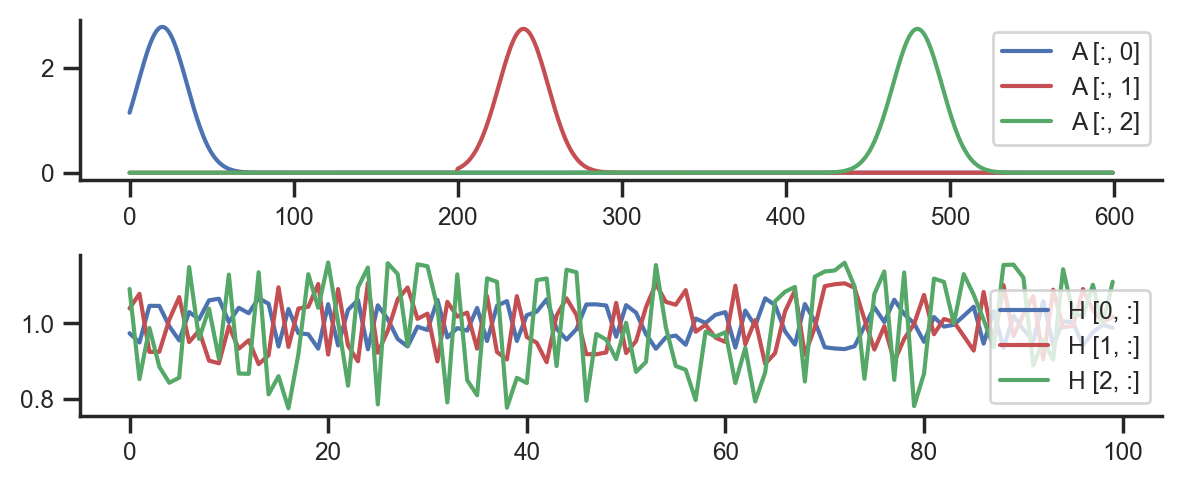

In [3]:
f, ax = plt.subplots(2, 1, figsize=(6,2.5))
ax[0].plot(A[:, 0], c='b', label='A [:, 0]')
ax[0].plot(A[:, 1], c='r', label='A [:, 1]')
ax[0].plot(A[:, 2], c='g', label='A [:, 2]')
ax[0].legend()

ax[1].plot(H[0, :], c='b', label='H [0, :]')
ax[1].plot(H[1, :], c='r', label='H [1, :]')
ax[1].plot(H[2, :], c='g', label='H [2, :]')
ax[1].legend()

plt.tight_layout()
plt.show()

In [4]:
A[:,0].shape

(600,)

In [5]:
device = 'cpu'


def parameter(x):
    return torch.tensor(x, requires_grad=True, dtype=torch.float32)


a_coef = {}
a_coef[0] = parameter([0.9, 0.1, 0.1])
a_coef[1] = parameter([0.1, 0.8, 0.2])
a_coef[2] = parameter([0.2, 0.3, 0.7])

a = {}
a[0] = parameter(np.random.rand(n_wavelengths, 1))
a[1] = parameter(np.random.rand(n_wavelengths, 1))
a[2] = parameter(np.random.rand(n_wavelengths, 1))

a[0] = parameter(0.2*s[0].reshape(n_wavelengths, 1) + 1.0*np.random.rand(n_wavelengths, 1))
a[1] = parameter(0.2*s[1].reshape(n_wavelengths, 1) + 1.0*np.random.rand(n_wavelengths, 1))
a[2] = parameter(0.2*s[2].reshape(n_wavelengths, 1) + 1.0*np.random.rand(n_wavelengths, 1))

h_coef = parameter([.1, .1])
h_bias = parameter([1.0, 1.0])
h01 = parameter(np.random.rand(1, n_timepoints)) # req. positive entries
h2 = parameter(np.random.rand(1, n_timepoints)) # req. positive entries

with torch.no_grad():
    # we want entries of h01 to be small compared to 1. (since we rely on 1-h01 to calculate h1)
    c = 0.5
    h01_norm = c * (h01.shape[1])**0.5 / torch.norm(h01, p=2)
    h01.data = (h01 * h01_norm)
    h_coef.data = h_coef / h01_norm

for p in [a_coef[0], a_coef[1], a_coef[2], a[0], a[1], a[2]]\
        + [h_coef, h_bias, h01, h2]:
    p.to(device)

# observation
X = torch.as_tensor(X, dtype=torch.float32, device=device)

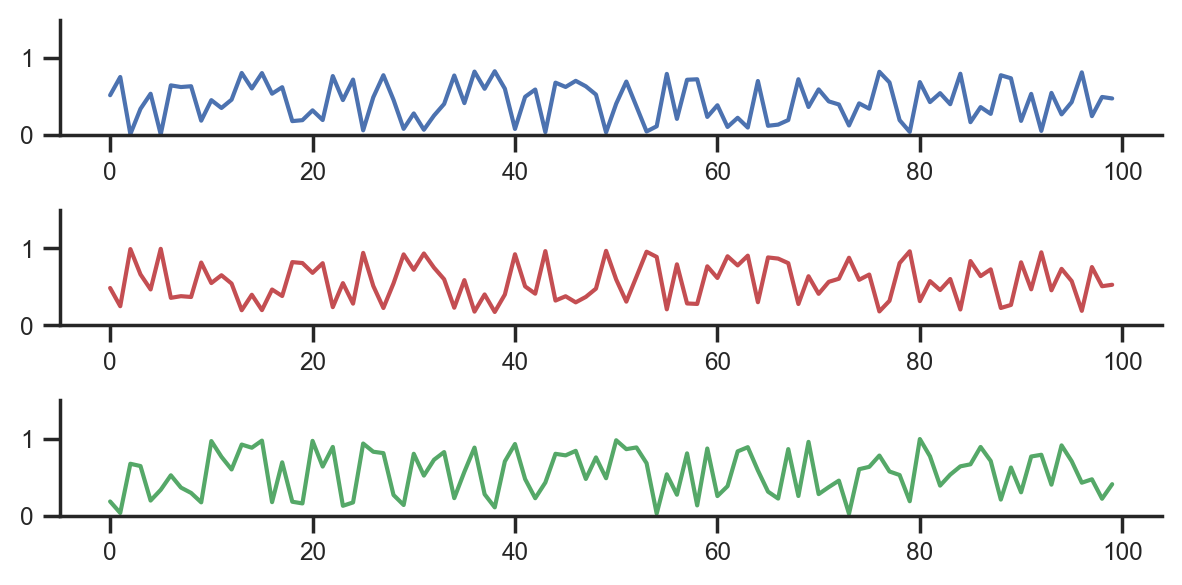

In [6]:
f, ax = plt.subplots(3, 1, figsize=(6,3))
ax[0].plot(np.ravel(h01.detach().numpy()),c='b')
ax[1].plot(np.ravel(1-h01.detach().numpy()), c='r')
ax[2].plot(np.ravel(h2.detach().numpy()), c='g')
for ax in ax:
    ax.set(ylim=(0,1.5))
plt.tight_layout()
plt.show()

In [7]:

# prox_plus = torch.nn.Threshold(0, 1e-4)
# with torch.no_grad():    
#     a_ = {}
#     for src in range(n_sources):
#         a_[src] = torch.cat(list(a_coef[ch][src]*a[src] for ch in range(n_channels)), dim=0)
#     A_ = torch.cat((a_[0], a_[1], a_[2]), dim=1)

#     h0_ = h_coef[0] * h01 + h_bias[0]
#     h1_ = prox_plus(h_coef[1] * (1-h01) + h_bias[1])
#     H_ = torch.cat((h0_, h1_, h2), dim=0)

#     X_ = torch.matmul(A_, H_)

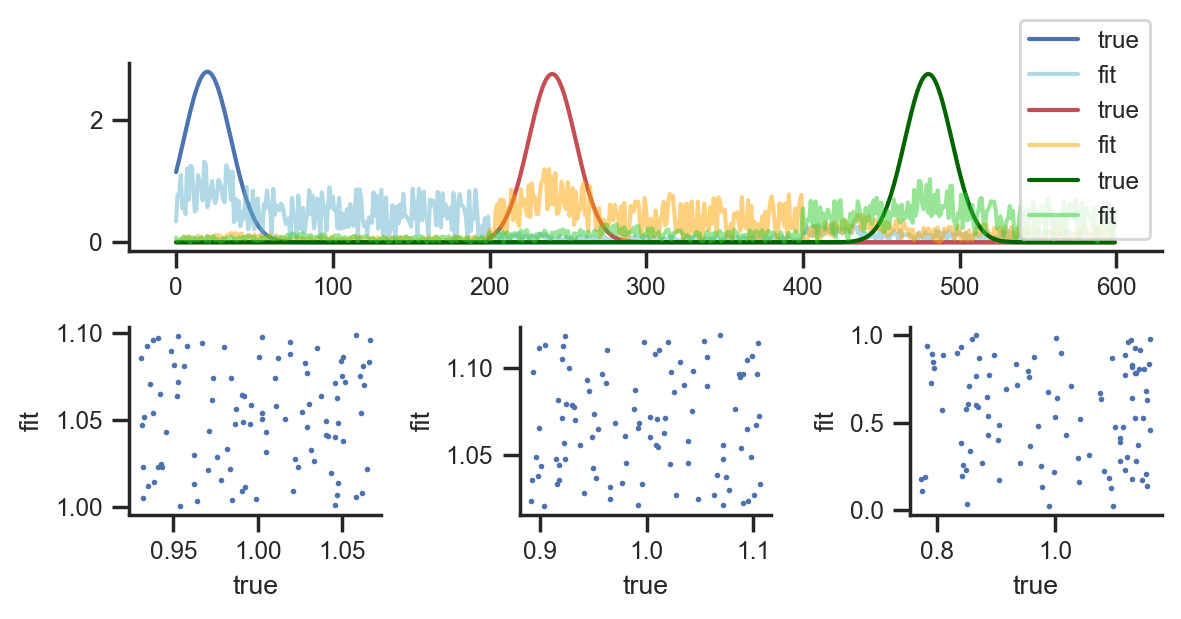

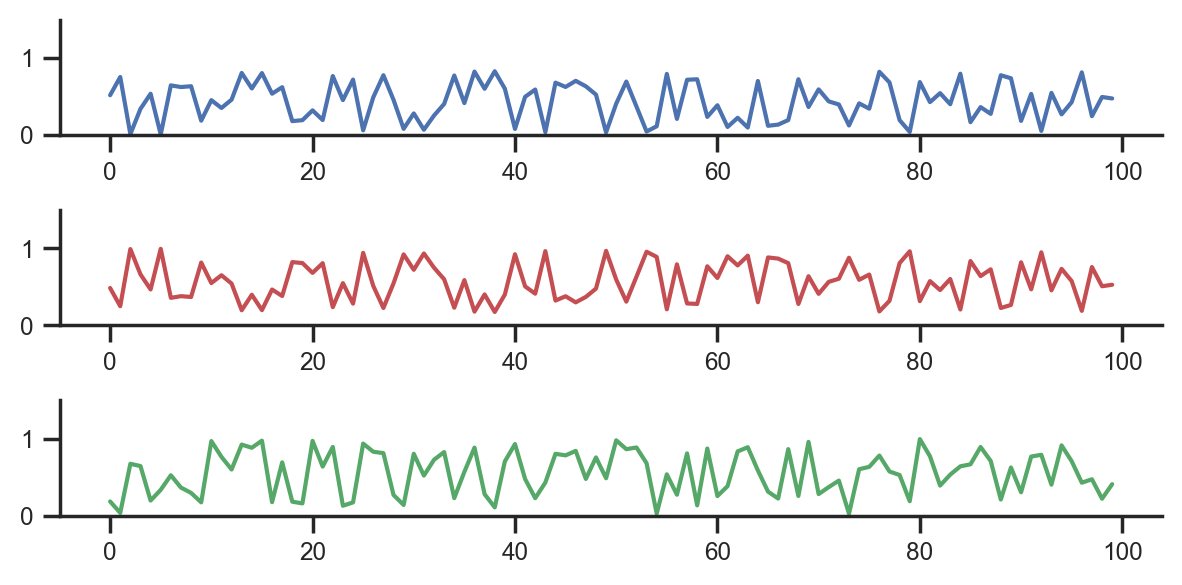

Step: 0, Loss: 38240.92578125
Step: 0, h_bias: tensor([0.9701, 0.9858], requires_grad=True)
Step: 0, h_coef: tensor([0.1054, 0.1109], requires_grad=True)
Step: 0, a_coef[0]: tensor([0.8574, 0.0786, 0.0641], requires_grad=True)
Step: 0, a_coef[1]: tensor([0.0858, 0.7475, 0.1667], requires_grad=True)
Step: 0, a_coef[2]: tensor([0.1453, 0.2345, 0.6202], requires_grad=True)


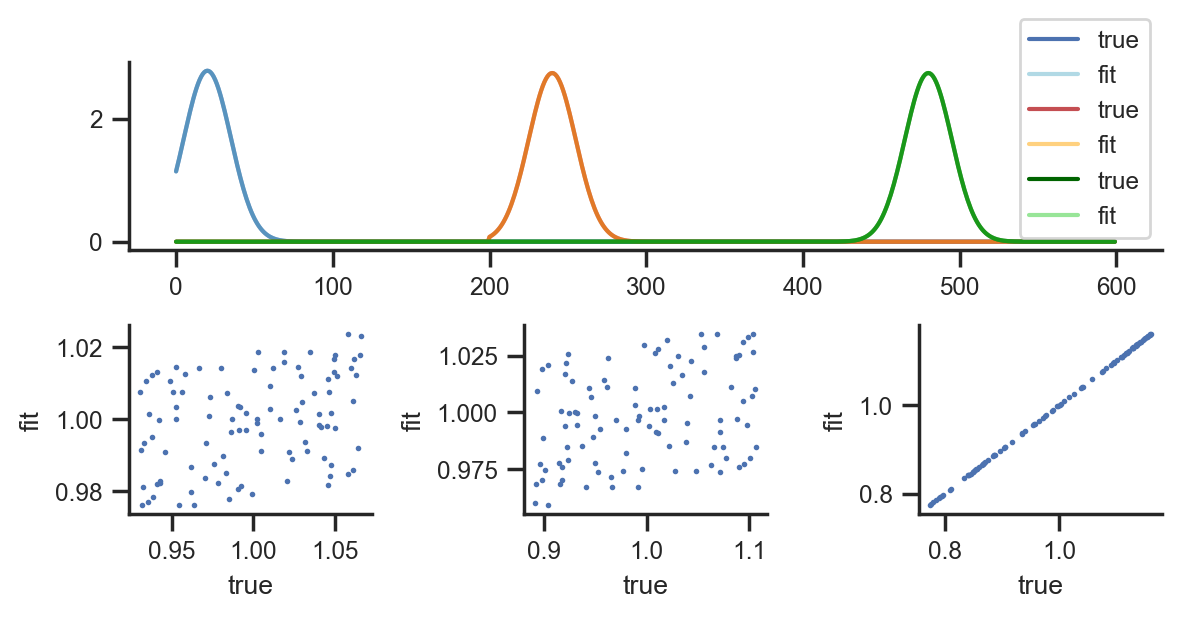

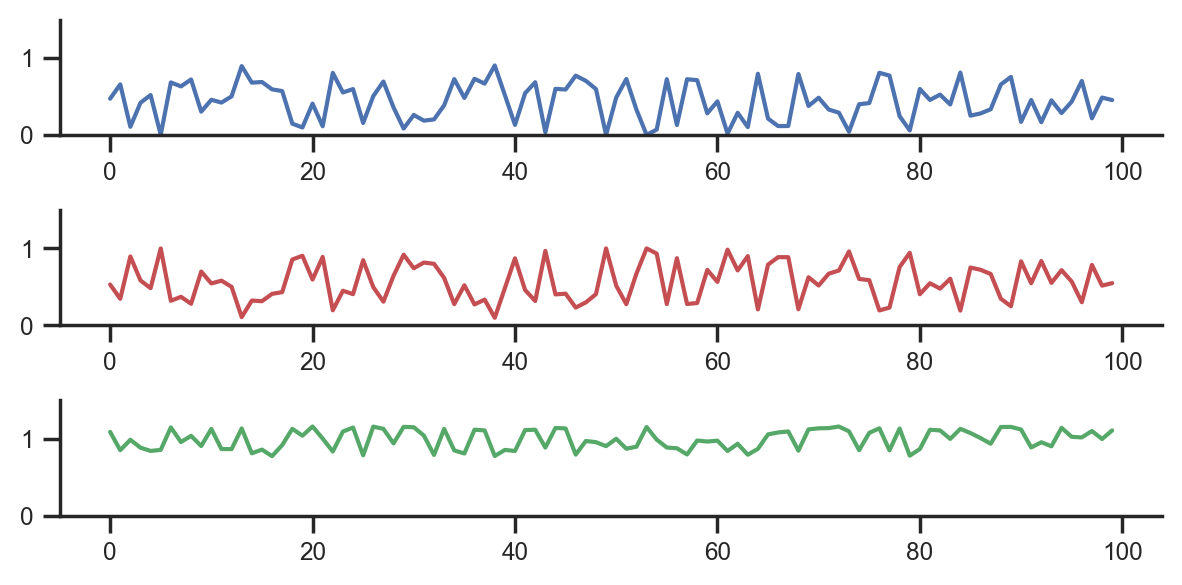

Step: 5000, Loss: 115.41596221923828
Step: 5000, h_bias: tensor([0.9761, 0.9510], requires_grad=True)
Step: 5000, h_coef: tensor([0.0527, 0.0836], requires_grad=True)
Step: 5000, a_coef[0]: tensor([1.0000e+00, 1.0000e-06, 1.0000e-06], requires_grad=True)
Step: 5000, a_coef[1]: tensor([1.0000e-06, 9.9955e-01, 4.4703e-04], requires_grad=True)
Step: 5000, a_coef[2]: tensor([1.0000e-06, 1.0000e-06, 1.0000e+00], requires_grad=True)


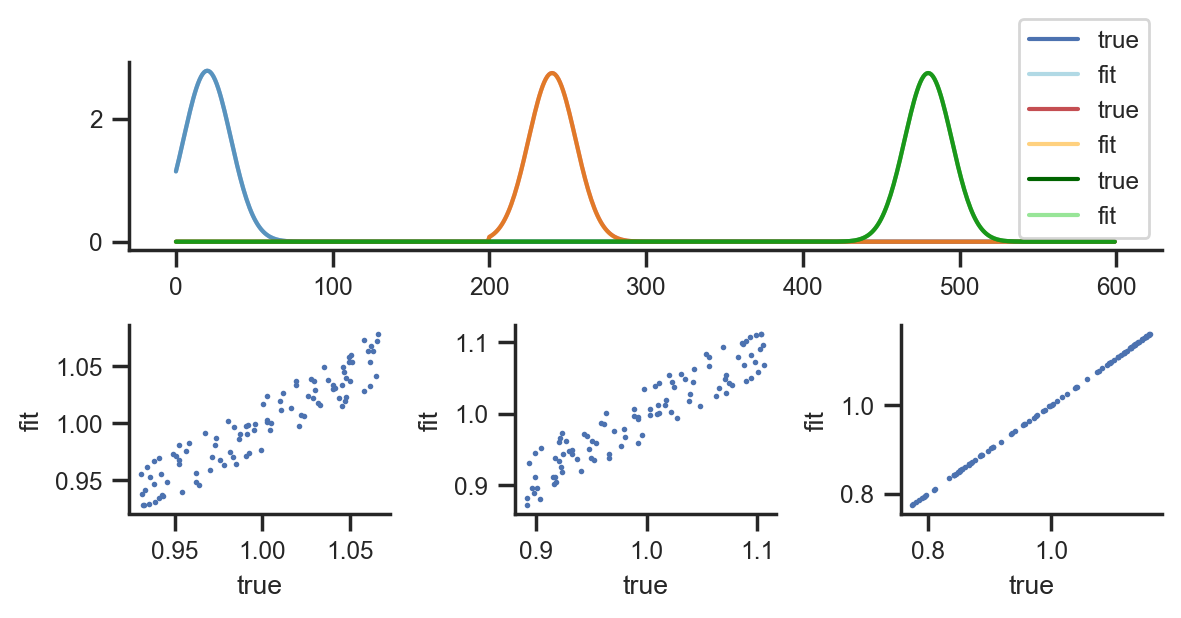

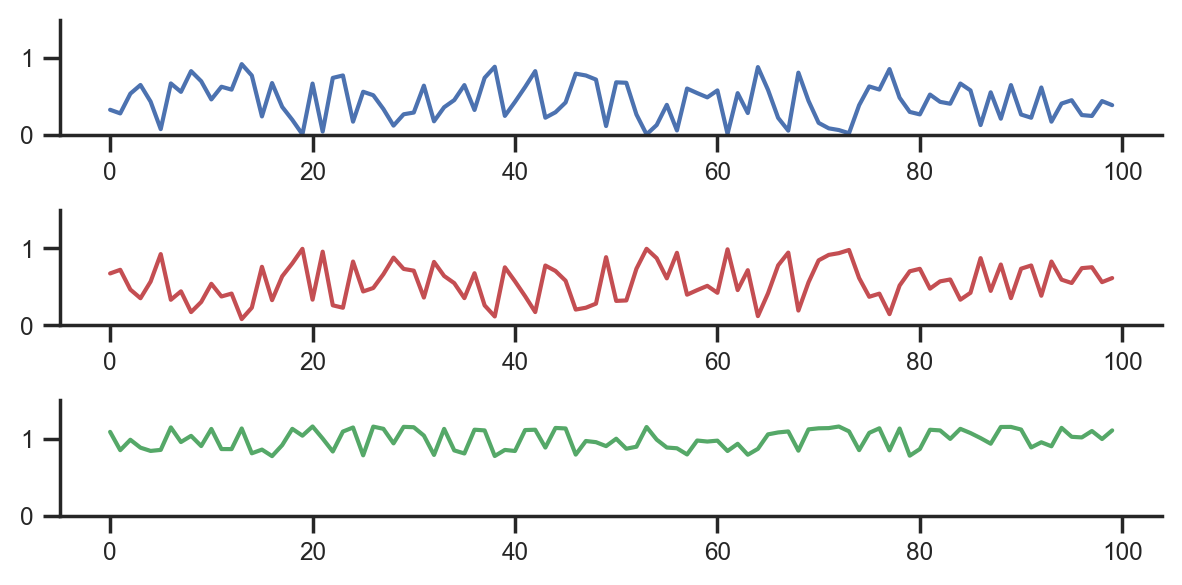

Step: 10000, Loss: 15.227948188781738
Step: 10000, h_bias: tensor([0.9271, 0.8516], requires_grad=True)
Step: 10000, h_coef: tensor([0.1645, 0.2614], requires_grad=True)
Step: 10000, a_coef[0]: tensor([1.0000e+00, 1.0000e-06, 1.0000e-06], requires_grad=True)
Step: 10000, a_coef[1]: tensor([1.0000e-06, 9.9891e-01, 1.0871e-03], requires_grad=True)
Step: 10000, a_coef[2]: tensor([3.2292e-07, 3.0122e-07, 1.0000e+00], requires_grad=True)


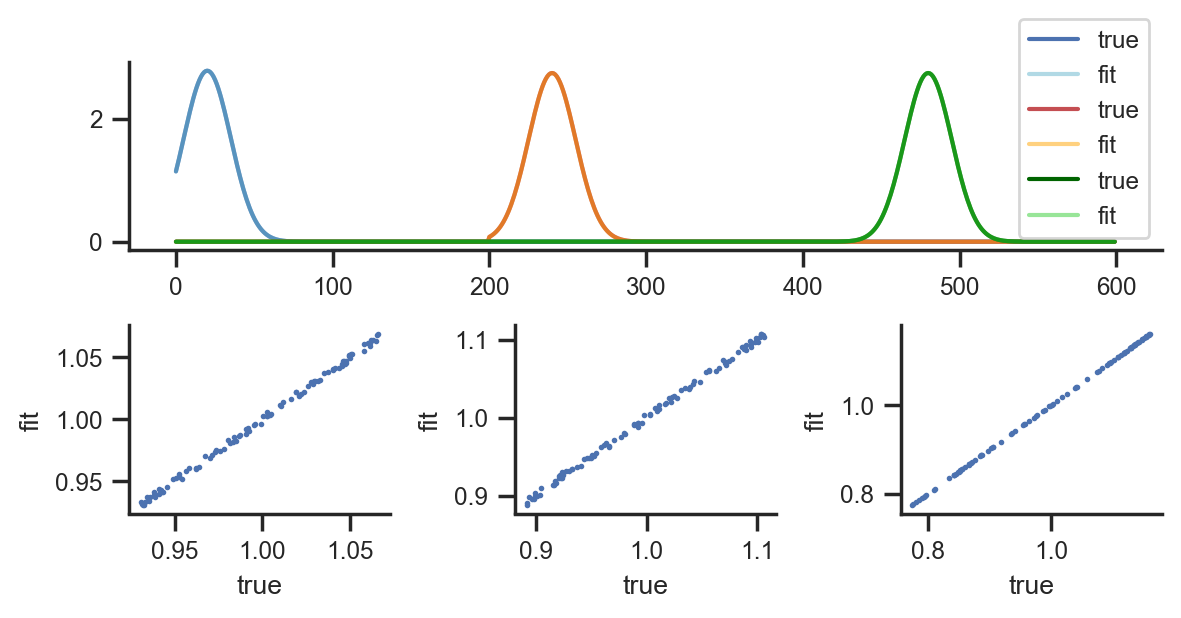

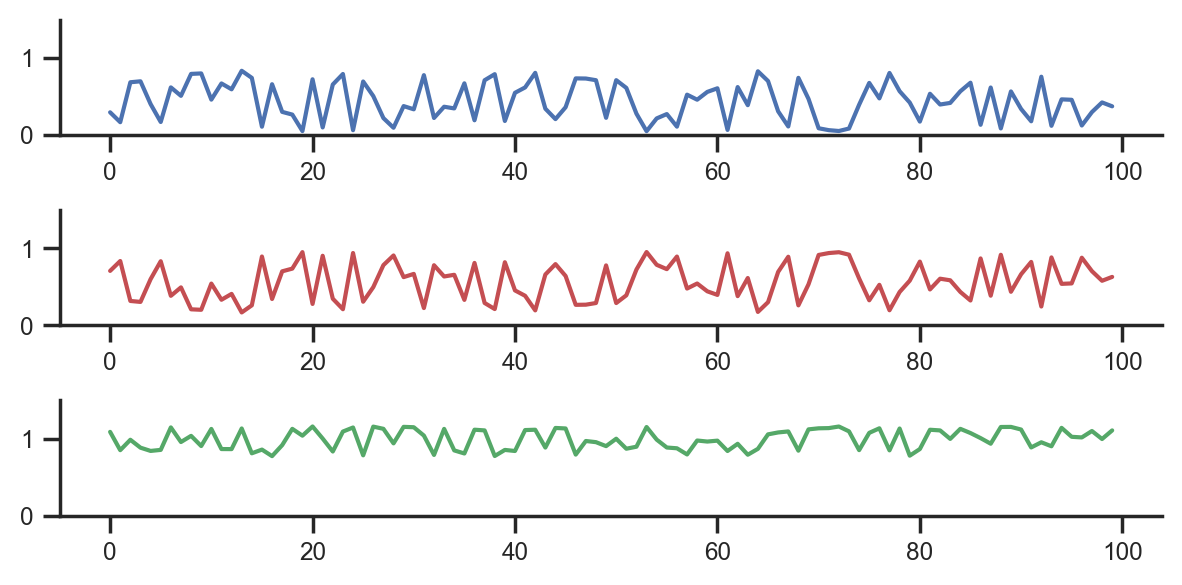

Step: 15000, Loss: 0.22515350580215454
Step: 15000, h_bias: tensor([0.9224, 0.8416], requires_grad=True)
Step: 15000, h_coef: tensor([0.1754, 0.2787], requires_grad=True)
Step: 15000, a_coef[0]: tensor([1.0000e+00, 1.0000e-06, 5.4685e-07], requires_grad=True)
Step: 15000, a_coef[1]: tensor([1.0000e-06, 9.9916e-01, 8.3508e-04], requires_grad=True)
Step: 15000, a_coef[2]: tensor([1.8898e-07, 1.0000e-06, 1.0000e+00], requires_grad=True)


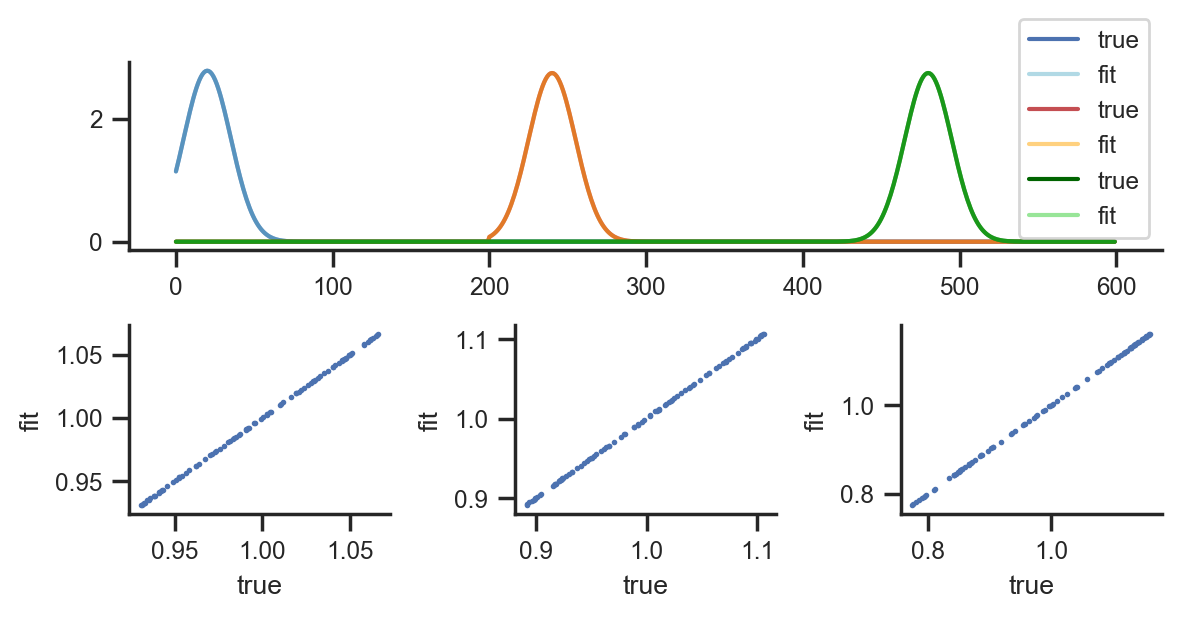

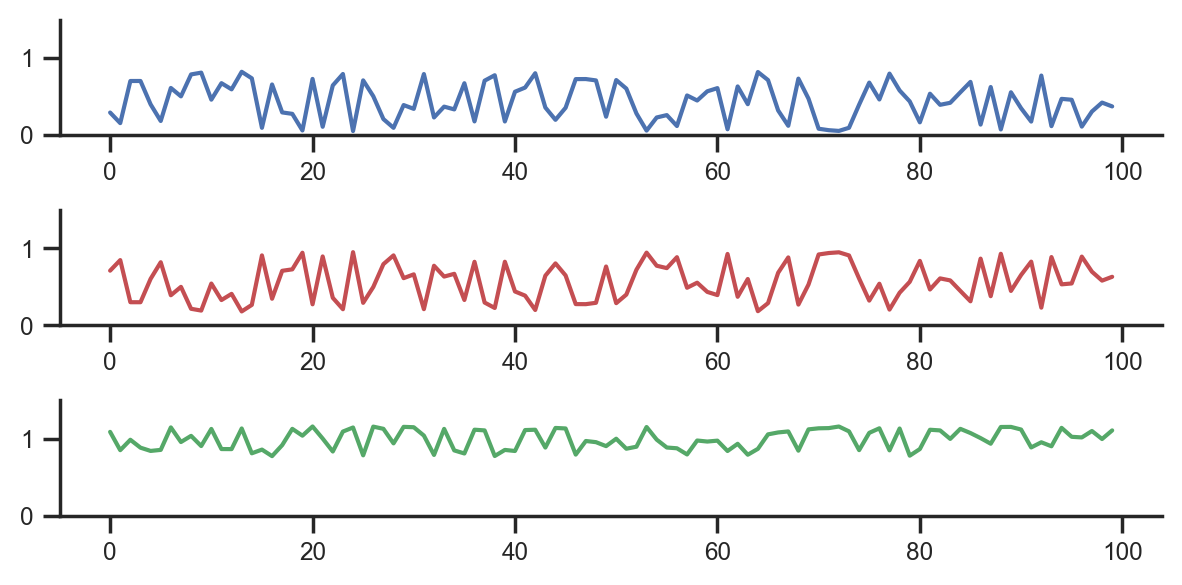

Step: 20000, Loss: 0.0031604536343365908
Step: 20000, h_bias: tensor([0.9223, 0.8413], requires_grad=True)
Step: 20000, h_coef: tensor([0.1756, 0.2789], requires_grad=True)
Step: 20000, a_coef[0]: tensor([1.0000e+00, 1.0000e-06, 1.3674e-07], requires_grad=True)
Step: 20000, a_coef[1]: tensor([1.0000e-06, 9.9934e-01, 6.5638e-04], requires_grad=True)
Step: 20000, a_coef[2]: tensor([4.7914e-08, 3.9551e-07, 1.0000e+00], requires_grad=True)


In [8]:
# learning rate
lr = 1e-5

# post gradient step modifiers:
min_value = 1e-6
prox_plus = torch.nn.Threshold(0, min_value)


def prox_norm(x):
    return (x / torch.norm(x, p=2))*torch.sqrt(torch.tensor(float(a[0].numel()), dtype=torch.float32))


for i in range(20000+1):
    a_ = {}
    for src in range(n_sources):
        a_[src] = torch.cat(list(a_coef[ch][src]*a[src] for ch in range(n_channels)), dim=0)
    A_ = torch.cat((a_[0], a_[1], a_[2]), dim=1)

    h0_ = h_coef[0] * h01 + h_bias[0]
    h1_ = prox_plus(h_coef[1] * (1-h01) + h_bias[1])
    H_ = torch.cat((h0_, h1_, h2), dim=0)

    X_ = torch.matmul(A_, H_)
    loss = torch.linalg.matrix_norm(X_ - X, ord='fro')**2
    loss.backward()

    with torch.no_grad():
        # project all values to non-negative side
        for p in [a[0], a[1], a[2],
                  a_coef[0], a_coef[1], a_coef[2],
                  h01, h2,
                  h_coef, h_bias]:
            p -= lr * p.grad
            p.grad.zero_()
            p.data = prox_plus(p)

        # scale for spectral shape from each source
        for p in [a[0], a[1], a[2]]:
            p.data = prox_norm(p)

        # sum of contribution across channels is 1
        for p in (a_coef[0], a_coef[1], a_coef[2]):
            p.data = p/torch.sum(p)

        # keep the norm of h01 to be 1, and scale h_coef accordingly
        # h2 does not need to be normalized this way
        c = 0.5
        h01_norm = c * (h01.shape[1])**0.5 / torch.norm(h01, p=2)
        h01.data = (h01 * h01_norm)
        h_coef.data = h_coef / h01_norm

    if i % 5000 == 0:

        # Create a grid of 2 rows and 3 columns
        gs = gridspec.GridSpec(2, 3, figure=plt.figure(figsize=(6, 3)))

        # This plot spans all columns of the first row
        ax1 = plt.subplot(gs[0, :])
        ax1.plot(A[:, 0], c='b', label='true')
        ax1.plot(A_[:, 0].detach().numpy(), alpha=0.5,  c='c', label='fit')
        ax1.plot(A[:, 1], c='r', label='true')
        ax1.plot(A_[:, 1].detach().numpy(), c='orange', alpha=0.5, label='fit')
        ax1.plot(A[:, 2], c='darkgreen', label='true')
        ax1.plot(A_[:, 2].detach().numpy(), c='limegreen', alpha=0.5, label='fit')
        ax1.legend()

        ax2 = plt.subplot(gs[1, 0])  # first column of the second row
        ax2.scatter(H[0, :], H_[0, :].detach().numpy(), s=1, label='true')
        ax2.set(xlabel='true', ylabel='fit')

        ax3 = plt.subplot(gs[1, 1])  # second column of the second row
        ax3.scatter(H[1, :], H_[1, :].detach().numpy(), s=1, label='true')
        ax3.set(xlabel='true', ylabel='fit')

        ax4 = plt.subplot(gs[1, 2])  # third column of the second row
        ax4.scatter(H[2, :], H_[2, :].detach().numpy(), s=1, label='true')
        ax4.set(xlabel='true', ylabel='fit')

        plt.tight_layout()
        plt.show()

        f, ax = plt.subplots(3, 1, figsize=(6,3))
        ax[0].plot(np.ravel(h01.detach().numpy()),c='b')
        ax[1].plot(np.ravel(1-h01.detach().numpy()), c='r')
        ax[2].plot(np.ravel(h2.detach().numpy()), c='g')
        for ax in ax:
            ax.set(ylim=(0,1.5))
        plt.tight_layout()
        plt.show()

        print(f'Step: {i}, Loss: {loss.item()}')
        print(f'Step: {i}, h_bias: {h_bias}')
        print(f'Step: {i}, h_coef: {h_coef}')
        print(f'Step: {i}, a_coef[0]: {a_coef[0]}')
        print(f'Step: {i}, a_coef[1]: {a_coef[1]}')
        print(f'Step: {i}, a_coef[2]: {a_coef[2]}')

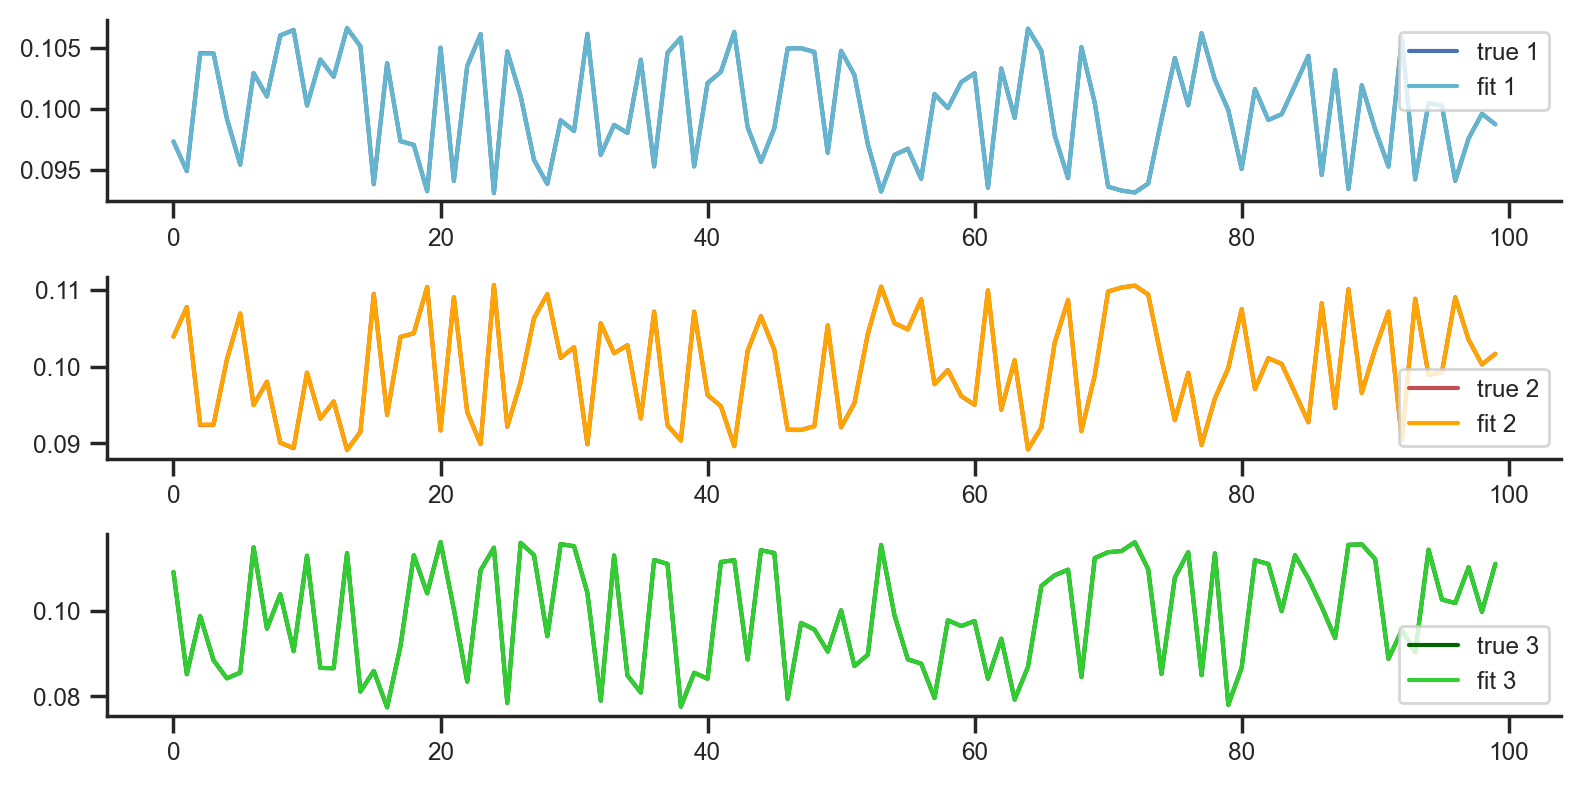

In [9]:
H_fit = H_.detach().numpy()

f, ax = plt.subplots(3, 1, figsize=(8,4))
ax[0].plot(set_norm(H[0, :], axis=0, c=1)[0], c='b', label='true 1')
ax[0].plot(set_norm(H_fit[0, :], axis=0, c=1)[0], c='c', label='fit 1')
ax[0].legend()
ax[1].plot(set_norm(H[1, :], axis=0, c=1)[0], c='r', label='true 2')
ax[1].plot(set_norm(H_fit[1, :], axis=0, c=1)[0], c='orange', label='fit 2')
ax[1].legend()
ax[2].plot(set_norm(H[2, :], axis=0, c=1)[0], c='darkgreen', label='true 3')
ax[2].plot(set_norm(H_fit[2, :], axis=0, c=1)[0], c='limegreen', label='fit 3')
ax[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
print('h_coef: ',h_coef)
print('h_bias: ',h_bias)

In [ ]:
# Chat with Kaspar:
# don't preprocess to get to df/f
# Use additive component near the laser wavelength and notch filter; 
# this is a practical fix but I don't understand why the laser spreads out in spectral space so much. 

# Next steps:
# Fitting seems robust for cases where:
# A is well-separated
# H goes to 0 <-- experiment with this in simulations 